In [ ]:
#import necessary libraries to use
!pip3 install keras-tuner
!pip install -U kera tensorflow
import cv2
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical,normalize
import keras
from keras.models import Sequential 
from keras.layers import Dense, Activation,Flatten, Dropout, Conv2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import glob
from xml.etree import ElementTree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras_tuner as kt

     |████████████████████████████████| 133 kB 2.7 MB/s 
ERROR: Could not find a version that satisfies the requirement kera (from versions: none)
ERROR: No matching distribution found for kera


Mounting Google Drive So I can Access Data From Drive Directly


In [ ]:
#mount google drive to be able to access dataset saved on the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#get image directories inorder to be able to access images
annotations_path = '/content/drive/MyDrive/Datasets/annotations'
images_path = '/content/drive/MyDrive/Datasets/images'
Dataset = '/content/drive/MyDrive/Datasets'




In [ ]:
#list some annotations samples
annotations_files = os.listdir('/content/drive/MyDrive/Datasets/annotations')
annotations_files[:5]

['maksssksksss11.xml',
 'maksssksksss112.xml',
 'maksssksksss114.xml',
 'maksssksksss111.xml',
 'maksssksksss113.xml']

In [ ]:
#list some image samples
images_files = os.listdir('/content/drive/MyDrive/Datasets/images')
images_files[:10]

['maksssksksss0.png',
 'maksssksksss110.png',
 'maksssksksss118.png',
 'maksssksksss109.png',
 'maksssksksss112.png',
 'maksssksksss11.png',
 'maksssksksss12.png',
 'maksssksksss114.png',
 'maksssksksss113.png',
 'maksssksksss102.png']

In [ ]:
#check the length of annotations and images
len(annotations_files), len(images_files)

(853, 853)

**Reading the XML annotation files for bounding boxes, cropping images and create a dataframe**


In [ ]:
import xml.etree.ElementTree as ET

def get_objects(xml_file):
  annotation = ET.parse(xml_file)
  root = annotation.getroot()
  objects = []
  for obj in root.findall('object'):
    new_object = {'name': obj.find('name').text}
    bbox_tree = obj.find('bndbox')
    new_object['bbox'] = (int(bbox_tree.find('xmin').text), 
                          int(bbox_tree.find('ymin').text), 
                          int(bbox_tree.find('xmax').text), 
                          int(bbox_tree.find('ymax').text),
                          )

    #TODO: fill the 4 dimensional vector with the coordinates.
    print(new_object)
    objects.append(new_object)
    
  return objects



{'name': 'with_mask', 'bbox': (180, 64, 222, 107)}
{'name': 'without_mask', 'bbox': (85, 65, 118, 103)}
{'name': 'without_mask', 'bbox': (135, 36, 154, 64)}
{'name': 'mask_weared_incorrect', 'bbox': (26, 42, 59, 85)}
{'name': 'mask_weared_incorrect', 'bbox': (341, 32, 385, 85)}


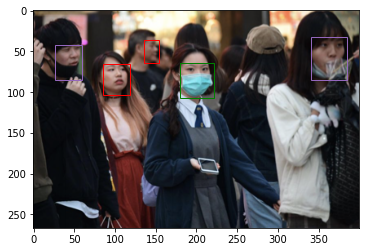

In [ ]:
# Color of the bounding boxes (depending on the class)
classes_color = {'with_mask':'g', 'without_mask':'r', 'mask_weared_incorrect':'tab:purple'}
classes_index = {'with_mask':0, 'without_mask':1, 'mask_weared_incorrect':2} 

def show_bboxes(image, objects, using_array_from_keras=False, using_grayscale=False):
  """
  Show plt image with annotation boundary boxes

  Arguments:
    image: image array data either from plt.imread or keras
    objects: annotation data boundaries
    using_array_from_keras: Sets in image arrary is from keras
    using_grayscale: Sets if image data is grayscale
  """
  fig,ax = plt.subplots(1)
  if using_array_from_keras:
    if using_grayscale:
      ax.imshow(image.squeeze()/255., cmap='gray')
    else:
      ax.imshow(image.squeeze()/255.)
  else:
    ax.imshow(image)

  for annotation in objects:
    xmin, ymin, xmax, ymax = annotation['bbox']
    rect = patches.Rectangle((xmin,ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor=classes_color[annotation['name']], facecolor='none')
    ax.add_patch(rect)
  plt.show()

index = 250
objects = get_objects(os.path.join(Dataset, 'annotations', 'maksssksksss' + str(index) + '.xml'))
image = plt.imread(os.path.join(Dataset, 'images', 'maksssksksss' + str(index) + '.png'))
show_bboxes(image, objects)

In [ ]:
# load in all images as grayscale and in array format, store image data in dictionary
from keras.preprocessing.image import load_img, save_img, img_to_array
dict_imgs = {}
for (_, _, files) in os.walk(images_path):
  for image_name in files:
    gray_img = load_img(images_path+'/'+image_name, color_mode='grayscale')
    img_array = img_to_array(gray_img)
    dict_imgs[image_name.split('.')[0]] = img_array

<function matplotlib.pyplot.show>

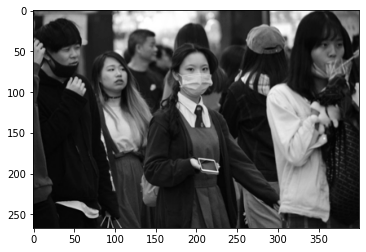

In [ ]:
plt.imshow(dict_imgs['maksssksksss250'].squeeze()/255., cmap='gray')
plt.show

{'name': 'with_mask', 'bbox': (180, 64, 222, 107)}
{'name': 'without_mask', 'bbox': (85, 65, 118, 103)}
{'name': 'without_mask', 'bbox': (135, 36, 154, 64)}
{'name': 'mask_weared_incorrect', 'bbox': (26, 42, 59, 85)}
{'name': 'mask_weared_incorrect', 'bbox': (341, 32, 385, 85)}


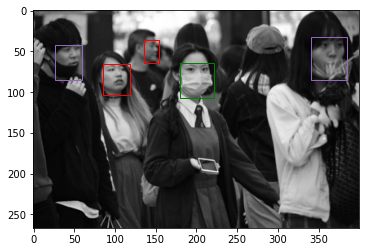

In [ ]:
annotations = get_objects(os.path.join(annotations_path,'maksssksksss' + str(250) + '.xml'))
show_bboxes(dict_imgs['maksssksksss250'], annotations, True, True)

In [ ]:
#create a variable called information that will store the cordinates and other information about the images
information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}

In [ ]:
#this section of code will help parse the xml images to retrieve the required information

for annotation in glob.glob(annotations_path + '/*.xml'):
    tree = ET.parse(annotation)
    
    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag: 
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))    

        if 'object' in element.tag:
            for attribute in list(element):
                
                if 'name' in attribute.tag:
                    name = attribute.text                 
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height] 
                    information['file'] += [annotation.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]                                
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]                                
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]



In [ ]:
#takes the information from each annotation file and put into a dataframe
annotations_info_df = pd.DataFrame(information)
annotations_info_df.head(5)

,xmin,ymin,xmax,ymax,label,file,width,height
0,23,114,77,172,mask_weared_incorrect,maksssksksss11,400,267
1,147,157,200,211,with_mask,maksssksksss11,400,267
2,201,191,230,234,with_mask,maksssksksss11,400,267
3,243,192,293,247,with_mask,maksssksksss11,400,267
4,309,182,346,224,with_mask,maksssksksss11,400,267


In [ ]:
#this code snippet will merge each image file to the corresponding annotation files
annotations_info_df['annotation_file'] = annotations_info_df['file'] + '.xml'
annotations_info_df['image_file'] = annotations_info_df['file'] + '.png'
 
#this is to convert grammatical spelling 'mask_weared_incorrect' to 'mask_not_properly_worn'
annotations_info_df.loc[annotations_info_df['label'] == 'mask_weared_incorrect', 'label'] = 'mask_not_properly_worn'
annotations_info_df.head(30)

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file
0,23,114,77,172,mask_not_properly_worn,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png
1,147,157,200,211,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png
2,201,191,230,234,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png
3,243,192,293,247,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png
4,309,182,346,224,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png
5,249,108,276,140,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png
6,275,99,303,128,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png
7,195,90,214,113,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png
8,214,76,237,99,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png
9,232,50,247,67,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png


In [ ]:
len(annotations_info_df)

4072

In [ ]:
#checking the label distributions accross all faces in all images
label_stat = {'with_mask':0, 'without_mask':0, 'mask_weared_incorrect':0, 'num_bbox':0}

size_of_the_dataset = 853

indexes = list(range(size_of_the_dataset))
for i in indexes:
    objects = get_objects(os.path.join(Dataset, 'annotations', 'maksssksksss' + str(i) + '.xml'))
    for d in objects:
        label_stat[d['name']] += 1
        label_stat['num_bbox'] += 1
    
label_stat['num_bbox_per_image'] = label_stat['num_bbox']/size_of_the_dataset
label_stat.values

{'name': 'without_mask', 'bbox': (79, 105, 109, 142)}
{'name': 'with_mask', 'bbox': (185, 100, 226, 144)}
{'name': 'without_mask', 'bbox': (325, 90, 360, 141)}
{'name': 'with_mask', 'bbox': (321, 34, 354, 69)}
{'name': 'with_mask', 'bbox': (224, 38, 261, 73)}
{'name': 'with_mask', 'bbox': (299, 58, 315, 81)}
{'name': 'with_mask', 'bbox': (143, 74, 174, 115)}
{'name': 'with_mask', 'bbox': (74, 69, 95, 99)}
{'name': 'with_mask', 'bbox': (191, 67, 221, 93)}
{'name': 'with_mask', 'bbox': (21, 73, 44, 93)}
{'name': 'with_mask', 'bbox': (369, 70, 398, 99)}
{'name': 'without_mask', 'bbox': (83, 56, 111, 89)}
{'name': 'with_mask', 'bbox': (68, 42, 105, 69)}
{'name': 'with_mask', 'bbox': (154, 47, 178, 74)}
{'name': 'with_mask', 'bbox': (238, 34, 262, 69)}
{'name': 'mask_weared_incorrect', 'bbox': (333, 31, 366, 65)}
{'name': 'with_mask', 'bbox': (52, 53, 73, 76)}
{'name': 'with_mask', 'bbox': (72, 53, 92, 75)}
{'name': 'with_mask', 'bbox': (112, 51, 120, 68)}
{'name': 'with_mask', 'bbox': (155

<function dict.values>

In [ ]:
#Next is to crop each face in all images
#first we will create a directory for saving all cropped images
cropped_images_path = 'cropped_images'
path = os.path.join(Dataset, cropped_images_path)
os.mkdir(path)

In [ ]:
# Copy The File Name (Before appending with .png extension)
annotations_info_df['cropped_image_file'] = annotations_info_df['file']
annotations_info_df.head(5)

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,23,114,77,172,mask_not_properly_worn,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
1,147,157,200,211,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
2,201,191,230,234,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
3,243,192,293,247,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
4,309,182,346,224,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11


In [ ]:
for a in range(len(annotations_info_df)):
    # Get The File Path and Read The Image
    image_filepath = '/content/drive/MyDrive/Datasets/images/' + annotations_info_df['image_file'].iloc[a]
    image = cv2.imread(image_filepath)
    
    # Set The Cropped Image File Name
    annotations_info_df['cropped_image_file'].iloc[a] = annotations_info_df['cropped_image_file'].iloc[a] + '-' + str(a) + '.png'
    cropped_image_filename = annotations_info_df['cropped_image_file'].iloc[a]
    
    # Get The xmin, ymin, xmax, ymax Value (Bounding Box) to Crop Image
    xmin = annotations_info_df['xmin'].iloc[a]
    ymin = annotations_info_df['ymin'].iloc[a]
    xmax = annotations_info_df['xmax'].iloc[a]
    ymax = annotations_info_df['ymax'].iloc[a]

    # Crop The Image Based on their bounding both values
    cropped_image = image[ymin:ymax, xmin:xmax]
   
    
    cropped_image_directory = os.path.join('/content/drive/MyDrive/Datasets/cropped_images/', cropped_image_filename)
    cv2.imwrite(cropped_image_directory, cropped_image)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
annotations_info_df.head(30)

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,23,114,77,172,mask_not_properly_worn,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-0.png
1,147,157,200,211,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-1.png
2,201,191,230,234,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-2.png
3,243,192,293,247,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-3.png
4,309,182,346,224,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-4.png
5,249,108,276,140,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-5.png
6,275,99,303,128,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-6.png
7,195,90,214,113,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-7.png
8,214,76,237,99,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-8.png
9,232,50,247,67,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-9.png


In [ ]:
len(annotations_info_df)

4072

<Figure size 576x576 with 0 Axes>

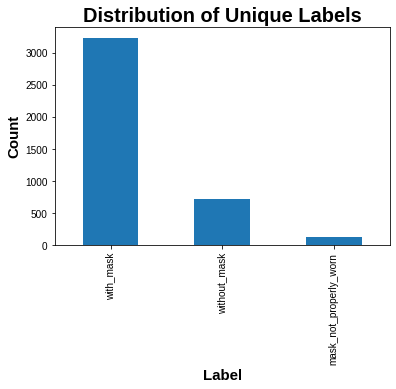

<Figure size 576x576 with 0 Axes>

In [ ]:
##count the number of images with mask, without mask and incorrectly worn masks
#and plots into a barchart
annotations_info_df['label'].value_counts().plot(kind='bar')
plt.xlabel('Label', fontsize = 15, fontweight = 'bold')
plt.ylabel('Count',fontsize = 15, fontweight = 'bold')
plt.title('Distribution of Unique Labels', fontsize = 20, fontweight = 'bold')
plt.style.use('seaborn')
plt.figure(figsize = (8, 8))


In [ ]:
#splittin data intp train and test dataset to be used for training and prediction
from sklearn.model_selection import StratifiedKFold
#X = annotations_info_df.drop(['label'], axis=1)
X=annotations_info_df
y = annotations_info_df['label']

print(X.shape, y.shape)
skf = StratifiedKFold(n_splits=5)
for train_indices,test_indices in skf.split(X,y):
 # print('train: %s, test: %s' % (train_indices, test_indices))
  X_train, X_test = X.iloc[train_indices,:], X.iloc[test_indices,:]
  y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

(4072, 11) (4072,)


In [ ]:
X_train.shape

(3258, 11)

In [ ]:
y_test.shape

(814,)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

In [ ]:
image_target_size = (int(60), int(60))

train_generator = datagen.flow_from_dataframe(
    dataframe = X_train,
    directory = '/content/drive/MyDrive/Datasets/cropped_images/',
    x_col = 'cropped_image_file',
    y_col = 'label',
    subset = 'training',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 2607 validated image filenames belonging to 3 classes.


In [ ]:
X_train=train_generator

In [ ]:
test_generator = datagen.flow_from_dataframe(
    dataframe = X_test,
    directory = '/content/drive/MyDrive/Datasets/cropped_images/',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 814 validated image filenames belonging to 3 classes.


In [ ]:
X_test=test_generator

In [ ]:
dict_cropped_images = {}
#print(cropped_image_directory)
def load_cropped_images(image_filenames):
  
  cropped_images = []
  for image_name in image_filenames:
    gray_cropped_img = cv2.imread(cropped_image_directory,0)
    resized_cropped_img = cv2.resize(gray_cropped_img, (32, 32), interpolation=cv2.INTER_NEAREST)
    cropped_images.append(resized_cropped_img)
  return cropped_images

In [ ]:
from pandas.core.frame import DataFrame
#loading all the cropped images in X_train, resizing and converting the list to np.array
X_train_images = load_cropped_images(X_train)
#X_train_images = datagen.flow_from_directory(X_train_images)

X_train_images = np.array(X_train_images)
X_train_images.shape


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


KeyboardInterrupt: ignored

In [ ]:
datagen.fit(X_train_images)

In [ ]:
#loading all the cropped images in X_test, resizing and converting the list to np.array
X_test_images = load_cropped_images(X_test['cropped_image_file'])
X_test_images = np.array(X_test_images)
X_test_images.shape

In [ ]:
#reshaping X-train images
X_train_images = X_train_images.reshape((X_train_images.shape[0],X_train_images.shape[1],X_train_images.shape[2],1))
X_test_images.shape


In [ ]:
#reshaping X_test_images
X_test_images = X_test_images.reshape((X_test_images.shape[0],X_test_images.shape[1],X_test_images.shape[2],1))
X_test_images.shape


In [ ]:
#encoding y_train and y_test to categorical
y_train.replace({'with_mask':0,'without_mask':1,'mask_not_properly_worn':2},inplace=True)
y_test.replace({'with_mask':0,'without_mask':1,'mask_not_properly_worn':2},inplace=True)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
print(y_test)

In [ ]:
#data normalization to between 0 and 1
train_norm = X_train_images.astype('float32')
test_norm = X_test_images.astype('float32')

X_train = train_norm/255.0
X_test = test_norm/255.0

print(X_train)

In [ ]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(32, 
                                                              32,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
#from operator import add
#def cnn_model(hyperModel):

 #   num_classes = 3 #we have 3 classes (with_mask, withou_mask and mask_not_correctly_worn)
      
  #  model = Sequential([
   # data_augmentation,                    
    #layers.Conv2D(16, 3, padding='same', activation='relu'),
    #layers.MaxPooling2D(pool_size=(2,2)),
    #layers.Conv2D(32, 3, padding='same', activation='relu'),
    #layers.MaxPooling2D(pool_size=(2,2)),
    #layers.Conv2D(64, 3, padding='same', activation='relu'),
    #layers.MaxPooling2D(pool_size=(2,2)),
    ##layers.Dropout(0.2),
    #hp_units = hyperModel.Int('units', min_value = 32, max_value = 512, step = 32)
    #layers.Flatten(),
    #layers.Dense(hp_units, activation='relu', kernel_initializer='he_uniform'),
    #layers.Dense(num_classes,activation='softmax')])
    

    #hp_learning_rate = hyperModel.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    #model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
    #  loss = keras.losses.CategoricalCrossentropy(), 
    #  metrics = ['accuracy'])
    #return model
    


In [ ]:
from operator import add
def cnn_model(hyperModel):
    #first layer group containing convolution, relu and maxpooling layers
    model = Sequential()
    data_augmentation
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides= (1,1), padding= 'same', activation = 'relu', kernel_initializer='he_uniform', input_shape=(32, 32, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))

   #second layer group containing convolution, relu and maxpooling layers
    model.add(Conv2D(filters=64, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

   #Flatten and dropout layer to stack the output convolutions above as well as cater overfitting
   #flatten converts the data into 1 dimensional layer which serves as input into the next layer
   #Dropout is used to avoid overfitting problems
    model.add(Flatten())
    hp_units = hyperModel.Int('units', min_value = 32, max_value = 512, step = 32)
    model.add(Dense(hp_units, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    hp_learning_rate = hyperModel.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
        loss = keras.losses.CategoricalCrossentropy(), 
        metrics = ['accuracy'])
    return model


In [ ]:
from tensorflow import keras
tuner = kt.Hyperband(cnn_model, objective = 'val_accuracy', max_epochs = 5, factor = 3, directory = './', project_name= 'FACEMASK CNN', overwrite = True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

tuner.search(X_train, y_train, epochs = 30, validation_split = .2, callbacks = [stop_early])

best_hps = tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

In [ ]:
#searching the best epoch with the highest accuracy
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train,y_train, epochs = 30, validation_split = 0.2)

#history = model.fit(datagen.flow(X_train, y_train, batch_size=32,
 #        subset='training'),validation_data=datagen.flow(X_train, y_train,
  #       batch_size=8, subset='validation'),
   #      steps_per_epoch=len(X_train) / 32, epochs=50)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
X_train.shape

In [ ]:
y_train = y_train.reshape((y_train.shape[0],y_train.shape[1],3,3))

In [ ]:
y_train.shape

In [ ]:
#now training the model
hyperModel = tuner.hypermodel.build(best_hps)
trained_model = hyperModel.fit(X_train, y_train, epochs = best_epoch, validation_split = 0.2,)

In [ ]:
#plot the model architecture
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(hyperModel, show_shapes=True)


In [ ]:
#Evaluating the model's performance
model_eval = hyperModel.evaluate(X_test, y_test)
print('[test loss, test accuracy]:', model_eval)

In [ ]:
#plotting the training and validation loss
from matplotlib import pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.Title('Training and Validation Accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.Title('Training and Validation Loss')

plt.show()

#plt.plot(trained_model.history['loss'], 'r', label = 'Training Loss')
#plt.plot(trained_model.history['val_loss'], 'b', label = 'Validation Loss')
#plt.xlabel('Number of Epochs')
#plt.ylabel('Loss Value')
#plt.legend()
#plt.show()

In [ ]:
#plotting the training and validation accuracy
#plt.plot(trained_model.history['accuracy'], 'r', label = 'Training Accuracy')
#plt.plot(trained_model.history['val_accuracy'], 'b', label = 'Validation Accuracy')
#plt.xlabel('Number of Epochs')
#plt.ylabel('Accuracy Value')
#plt.legend()
#plt.show()

In [ ]:
#confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), hyperModel.predict(X_test).argmax(axis=1))

In [ ]:
#classification report
print(classification_report(y_test.argmax(axis=1), hyperModel.predict(X_test).argmax(axis=1)))

In [ ]:
import pickle
 
# Save the trained model as a pickle string.
Face_Mask_Detection_Alert_System = pickle.dumps(hyperModel)


**REAL-TIME** **DETECTION** 


In [ ]:
#To be able to detect real time, we have to load our saved model
#first we import necessary libraries
!pip install smtplib
import tkinter as tk
from tkinter import messagebox
import smtplib #this will send a mail to the concerned officers if a customer is not wearing a mask


In [ ]:
#initialize tkinter
root = tk.Tk( screenName=" ", className="")
root.withdraw()

In [ ]:
# Load the pickled model
Face_Mask_Detection_Alert_System = pickle.loads(Face_Mask_Detection_Alert_System)

In [ ]:
#create a classifier object to detect faces
face_det_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
#capture video or picture to detect mask
vid_source = cv2.VideoCapture(0)

In [ ]:
#dictionaries containing details of wearing mask and create a bounding box around face
#if wearing mask, bounding box will be green else will be red.
text_dict = {0:'with_mask', 1:'without_mask', 2:'mask_not_properly_worn'}
rect_color_dict = {0: (0,255,0), 1: (0,0,255), 1: (128,0,128)}

In [ ]:
#This section will provide details of the email that will be sent
SUBJECT = "Subject"
TEXT = "Face Mask Rule Violation Detected!. An incoming visitor at the reception area  is unmasked."
# Photo Captured:

#while loop to continously detect camera feed
while(True):
	ret, img =vid_source.read()
	grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	faces = face_det_classifier.detectMultiscale(grayscale_img, 1.3, 5)

In [ ]:
for (x,y,w,h) in faces:
		face_img =grayscale_img[y:y+w, x:x+w]
		resized_img = cv2.resize(face_img, (112,112))
		normalized_img = resized_img/255.0
		reshaped_img = np.reshape(normalized_img, (1,112,112,1))
		result = model.predict(reshaped_img)

		label = np.argmax(result, axis=1)[0]

		cv2.rectangle(img,(x,y),(x+w,y+h),rect_color_dict[label],2)
		cv2.rectangle(img,(x,y-40),(x+w,y),rect_color_dict[label],-1)
		cv2.putText(img, text_dict[label], (x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,0,0),2)


In [ ]:
if (label == 1):
	messagebox.showwarning("Warning", "Access Denied. Please wear a face mask")

	#send an email to the administrative officer
	message = 'Subject: {}\n\n{}'.format(SUBJECT, TEXT)
	mail = smtplib.SMTP('smtp.gmail.com', 587)
	mail.ehlo()
	mail.starttls()
	mail.login('folafoyeg@gmail.com')
	mail.sendmail('folafoyeg@gmail.com','folafoyeg@gmail.com',message)
	mail.close
else:
	pass
	break

cv2.imshow('LIVE Video Feed', img)
key=cv2.waitKey(1)

if(key==27):
	break

cv2.destroyAIWindows()
source.release()